In [47]:
clear all
cd /braintree/home/kohitij/lib/matlab/2021_faceEmotion_ASD/
addpath(genpath(pwd))
load('data/amygdala_firing_rates.mat')
load('/braintree/data2/active/users/kohitij/processeddata/faces.bti/alexnet_pred_fe.mat')

In [55]:
% Get the internal consistencies of each recorded site
intcon = get_internalConsistency(rates_sh1, rates_sh2,[], time, [250 1500]);
disp(['Number of sites with reliability >0 = ', num2str(sum(intcon>0.1))])

Number of sites with reliability >0 = 135


Visual Drive Test

In [67]:
vis_drive_test = nan(442,1);
for i = 1:442,
     [~,vis_drive_test(i)] = signrank(nanmean(rates(:,i,time<0),3),nanmean(rates(:,i,time>=250&time<=1000),3));
end
disp(['Number of visual driven cell = ', num2str(sum(vis_drive_test==1))])
valid_neurons = vis_drive_test==1;

Number of visual driven cell = 132


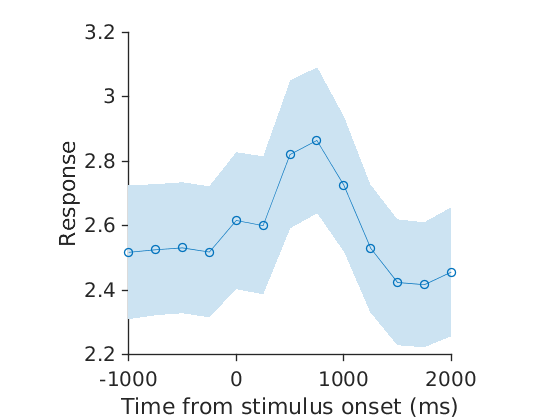

In [69]:
boundedline(time,squeeze(nanmean(nanmean(rates(:,vis_drive_test==1,:),1),2)),squeeze(mad(nanmean(rates(:,vis_drive_test==1 ,:),1),[],2))./sqrt(sum(vis_drive_test==1)))
hold on
plot(time,squeeze(nanmean(nanmean(rates(:,vis_drive_test==1,:),1),2)),'o')
polishFigure;
xlabel('Time from stimulus onset (ms)');
ylabel('Response');

Get the Behavioral Data

In [49]:
load('data/behavioral_data.mat');
load('data/meta.mat')
ctrl = get_behavioral_matrix('behavior',behavior, 'condition','ASD_Ctrl');
asd = get_behavioral_matrix('behavior',behavior, 'condition','ASD');
ctrl = reshape(ctrl,[],size(ctrl,3));
asd = reshape(asd,[],size(asd,3));

Get Amygdala Neural Predictions from a Regression Model

In [50]:
% valid_neurons = intcon>0;
features = zscore(nanmean(rates(:,valid_neurons,time>=250&time<=1500),3),[],2)';
disp(size(features))
neural_predictions = get_neuralTestPredictions('neu_features', features, 'happy_values',happy_groundTruth_behavData, 'ncomp',15);

   120    28



Figure 5B

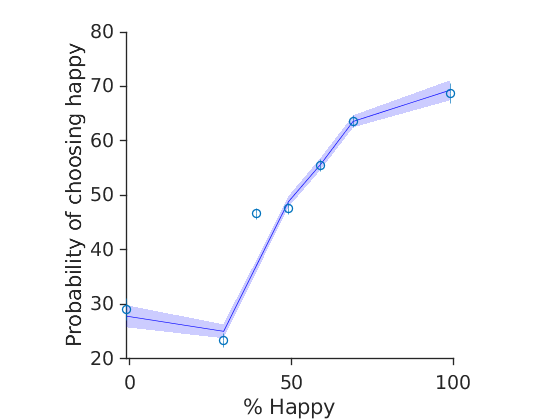

In [51]:
uHappy = unique(happy_groundTruth_behavData);
pr = nan(length(uHappy), 1);
pr_err= nan(length(uHappy), 1);
for i = 1:length(uHappy) 
    pr(i,1) = nanmean(mean(neural_predictions(happy_groundTruth_behavData==uHappy(i),:),1),2);
    pr_err(i,1) = std(mean(neural_predictions(happy_groundTruth_behavData==uHappy(i),:),1),[],2);
 
end

fig=figure;
yFit = smooth(uHappy, pr,'rlowess');
boundedline(uHappy-1, yFit-1, pr_err(:,end), 'b', 'alpha')
hold on
errorbar(uHappy-1, pr(:,end)-1, pr_err(:,end), 'o', 'capsize', 0);
journalFigure(0)
xlabel('% Happy')
ylabel('Probability of choosing happy')

Get correlation of neu_pred vs. behavior

Figure 5C

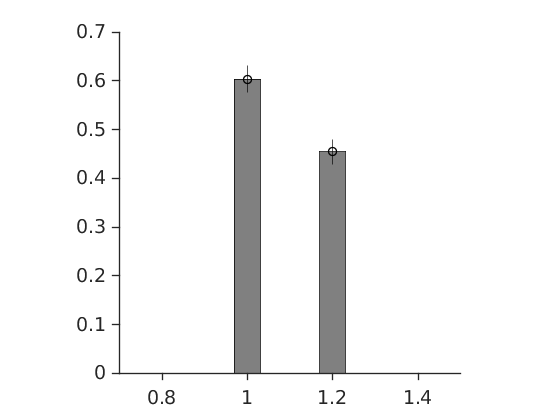

In [52]:
[consis_ctrl,consis_asd] = get_Amyg_behavPredictivity('neural_rates',rates,...
                                                       'timelimit', [250 1500],...
                                                       'happy_labels',happy_groundTruth_behavData,...
                                                       'ctrl_behavior',ctrl, 'asd_behavior', asd,...
                                                       'difference_level',0.02,...
                                                       'valid_neural_ind',valid_neurons);
fig = figure;
bar([1,1.2], [nanmean(nanmean(consis_ctrl,2)), nanmean(nanmean(consis_asd,2))], 'barwidth', 0.3, 'facecolor',[0.5 0.5 0.5]);
hold on;
errorbar([1,1.2], [nanmean(nanmean(consis_ctrl,2)), nanmean(nanmean(consis_asd,2))], [mad(nanmean(consis_ctrl,2)), mad(nanmean(consis_asd,2))],'ko', 'capsize',0);
journalFigure(0)
% ylim([0.2 0.5])
xlim([0.7 1.5])

How does the discrimination of ASD and Control behavior from Amygdala activity depend on image selection?

     1

     2

     3

     4

     5

     6

     7

     8

     9

done


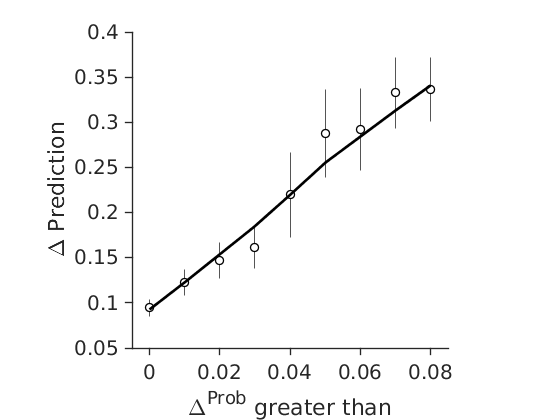

In [53]:
bins = [0:0.01:0.08];
consis_ctrl = nan(100,length(bins));
consis_asd = nan(100,length(bins));
parfor i = 1:length(bins)
    disp(i)
    [consis_ctrl(:,i),consis_asd(:,i)] = get_Amyg_behavPredictivity('neural_rates',rates,...
                                                       'timelimit', [250 1500],...
                                                       'happy_labels',happy_groundTruth_behavData,...
                                                       'ctrl_behavior',ctrl, 'asd_behavior', asd,...
                                                       'difference_level',bins(i),...
                                                       'valid_neural_ind',valid_neurons);
end
disp('done')
errorbar(bins,nanmean((consis_ctrl-consis_asd)),std((consis_ctrl-consis_asd)),'ko','capsize',0,'markerfacecolor','w');
yFit = smooth(bins,nanmean((consis_ctrl-consis_asd)),'rlowess');
hold on
plot(bins,yFit,'k', 'linewidth',2)
polishFigure
ylabel('\Delta Prediction')
xlabel('\Delta^{Prob} greater than')
xlim([-0.005 0.085])